# Modelisation des intensités des emissions de CO2

## Import des librairies et du dataset

In [ ]:
!pip install shap
!pip install lime
import shap
import lime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from lime import lime_tabular
from sklearn.dummy import DummyRegressor

In [ ]:
## Import du dataset

%cd "Chemin vers Dataset"

df_Building_energy = pd.read_csv("df_Building_energy.csv", sep=',')

C:\Users\33769\OneDrive\Bureau\DataScientist\Projets\Projet_4


## Informations et decription du dataset

In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 60)

In [ ]:
df_Building_energy 

,Unnamed: 0,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,5,Nonresidential COS,Other,West Precinct,810 Virginia St,98101.0,7,DOWNTOWN,47.61623,-122.33657,1999,2,97288,37198,60090,Police Station,88830.0,no secondary use,NaN,no tertiary use,NaN,NaN,136.100006,141.600006,316.299988,320.500000,1.208662e+07,1.258171e+07,0.000,7.371434e+06,4.715182e+06,False,non outlier,301.81,3.10
1,7,NonResidential,Other,Paramount Theatre,911 Pine St,98101.0,7,DOWNTOWN,47.61327,-122.33136,1926,8,102761,0,102761,Other - Entertainment/Public Assembly,102761.0,no secondary use,NaN,no tertiary use,NaN,NaN,61.299999,68.800003,141.699997,152.300003,6.298132e+06,7.067882e+06,2276286.500,3.636655e+06,3.851890e+05,False,non outlier,221.51,2.16
2,15,Nonresidential COS,Other,The Seattle Public Library - Central Library,1000 Fourth Avenue,98154.0,7,DOWNTOWN,47.60649,-122.33297,2004,11,412000,57000,355000,Library,364913.0,Parking,49000.0,Data Center,1074.0,NaN,50.799999,51.099998,155.600006,156.000000,1.858886e+07,1.870691e+07,737559.500,1.785130e+07,0.000000e+00,False,non outlier,181.38,0.44
3,16,NonResidential,Other,Downtown Seattle YMCA,909 4th Avenue,98104.0,7,DOWNTOWN,47.60546,-122.33279,1930,6,103911,0,103911,Fitness Center/Health Club/Gym,90000.0,Office,40000.0,Swimming Pool,0.0,NaN,76.599998,78.400002,157.399994,159.600006,9.956396e+06,1.019212e+07,4592347.500,4.453868e+06,9.101800e+05,False,non outlier,433.86,4.18
4,18,NonResidential,Mixed Use Property,The Rainier Club,820 4th Ave.,98104.0,7,DOWNTOWN,47.60515,-122.33159,1907,5,57452,0,57452,Social/Meeting Hall,16442.0,Restaurant,15505.0,Office,9741.0,NaN,132.399994,137.100006,280.700012,285.000000,7.606084e+06,7.877219e+06,1776201.875,3.764791e+06,2.065091e+06,False,non outlier,273.02,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,3371,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,98108.0,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1,12294,0,12294,Office,12294.0,no secondary use,NaN,no tertiary use,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.000,5.242709e+05,3.254750e+05,True,non outlier,20.94,1.70
1509,3372,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,98104.0,2,DOWNTOWN,47.59625,-122.32283,2004,1,16000,0,16000,Other - Recreation,16000.0,no secondary use,NaN,no tertiary use,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.000,3.965461e+05,5.537300e+05,False,non outlier,32.17,2.01
1510,3373,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,98101.0,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.000,1.792159e+06,3.973739e+06,False,non outlier,223.54,16.99
1511,3374,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,98108.0,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.000,3.488702e+05,3.706010e+05,False,non outlier,22.11,1.57


In [ ]:
del df_Building_energy["Unnamed: 0"]

In [ ]:
df_Building_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1513 non-null   object 
 1   PrimaryPropertyType              1513 non-null   object 
 2   PropertyName                     1513 non-null   object 
 3   Address                          1513 non-null   object 
 4   ZipCode                          1513 non-null   float64
 5   CouncilDistrictCode              1513 non-null   int64  
 6   Neighborhood                     1513 non-null   object 
 7   Latitude                         1513 non-null   float64
 8   Longitude                        1513 non-null   float64
 9   YearBuilt                        1513 non-null   int64  
 10  NumberofFloors                   1513 non-null   int64  
 11  PropertyGFATotal                 1513 non-null   int64  
 12  PropertyGFAParking  

In [ ]:
df_Building_energy.describe()

,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1.513000e+03,1513.000000,1.513000e+03,1.508000e+03,771.000000,307.000000,973.000000,1510.000000,1510.000000,1511.000000,1511.000000,1.511000e+03,1.510000e+03,1.511000e+03,1.511000e+03,1.511000e+03,1511.000000,1511.000000
mean,98117.202247,4.256444,47.614898,-122.333016,1961.851289,3.832783,1.165883e+05,12389.051553,1.041992e+05,9.769449e+04,36431.464717,14283.369377,65.985612,71.785497,74.182782,177.380477,179.487359,8.348372e+06,7.910338e+06,4.765359e+05,5.914067e+06,1.837612e+06,175.607737,1.552052
std,18.101531,2.195248,0.049130,0.025116,32.220096,6.447011,3.057704e+05,42659.059222,2.931479e+05,2.870274e+05,69786.917579,37104.179235,28.500953,76.636822,77.596503,193.728032,193.667963,3.148852e+07,2.275073e+07,5.675696e+06,2.169826e+07,9.718641e+06,777.388349,2.374095
min,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,1.128500e+04,0.000000,1.092500e+04,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,-0.800000,-0.020000
25%,98105.000000,2.000000,47.582170,-122.343380,1931.000000,1.000000,2.884100e+04,0.000000,2.793300e+04,2.508025e+04,5045.500000,2583.500000,49.000000,32.349999,34.500000,74.000000,77.099998,1.158892e+06,1.233055e+06,0.000000e+00,6.956805e+05,0.000000e+00,18.750000,0.330000
50%,98114.000000,4.000000,47.611660,-122.332820,1965.000000,2.000000,4.736800e+04,0.000000,4.568000e+04,4.219000e+04,11520.000000,5931.000000,75.000000,50.049999,52.450001,126.000000,130.399994,2.371575e+06,2.498229e+06,0.000000e+00,1.537923e+06,3.991220e+05,46.460000,0.800000
75%,98125.000000,7.000000,47.649130,-122.321570,1988.000000,4.000000,9.944000e+04,0.000000,9.243700e+04,8.811825e+04,30232.500000,12379.500000,89.000000,78.375002,82.475000,204.050003,205.000000,6.553759e+06,6.768524e+06,0.000000e+00,4.788646e+06,1.265570e+06,123.560000,1.705000
max,98199.000000,7.000000,47.733870,-122.258640,2015.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


### Creation d'une feature % of energy from SteamUse, Electricity and Natural Gas

In [ ]:
df_Building_energy["part_SteamUse"] = df_Building_energy["SteamUse(kBtu)"]/(df_Building_energy["SteamUse(kBtu)"]
                                                                            +df_Building_energy["Electricity(kBtu)"]
                                                                            +df_Building_energy["NaturalGas(kBtu)"])

df_Building_energy["part_NaturalGas"] = df_Building_energy["NaturalGas(kBtu)"]/(df_Building_energy["SteamUse(kBtu)"]
                                                                            +df_Building_energy["Electricity(kBtu)"]
                                                                            +df_Building_energy["NaturalGas(kBtu)"])

df_Building_energy["part_Electricity"]  = df_Building_energy["Electricity(kBtu)"]/(df_Building_energy["SteamUse(kBtu)"]
                                                                            +df_Building_energy["Electricity(kBtu)"]
                                                                            +df_Building_energy["NaturalGas(kBtu)"])

### Creation d'une feature % d'aire des 3 usages de chaque propriété

In [ ]:
df_Building_energy["part_LargestPropertyUseTypeGFA"] = df_Building_energy["LargestPropertyUseTypeGFA"]/(df_Building_energy['PropertyGFATotal'])

df_Building_energy["part_SecondLargestPropertyUseTypeGFA"] = df_Building_energy["SecondLargestPropertyUseTypeGFA"]/(df_Building_energy['PropertyGFATotal'])

df_Building_energy["part_ThirdLargestPropertyUseTypeGFA"]  = df_Building_energy["ThirdLargestPropertyUseTypeGFA"]/(df_Building_energy['PropertyGFATotal'])

## Préparation du dataset pour modelisation

In [ ]:
df_modelisation = df_Building_energy.copy()

# supression des colonnes non utilisées pour la modelisation

del df_modelisation["BuildingType"]
del df_modelisation["PropertyName"]
del df_modelisation["Address"]
del df_modelisation["DefaultData"]
del df_modelisation["ENERGYSTARScore"]
del df_modelisation["SteamUse(kBtu)"]
del df_modelisation["NaturalGas(kBtu)"]
del df_modelisation["Electricity(kBtu)"]
del df_modelisation["SiteEUI(kBtu/sf)"]
del df_modelisation['SiteEUIWN(kBtu/sf)']
del df_modelisation['SourceEUI(kBtu/sf)']
del df_modelisation['SourceEUIWN(kBtu/sf)']
del df_modelisation['PropertyGFATotal']
del df_modelisation['PropertyGFAParking']
del df_modelisation['PropertyGFABuilding(s)']
del df_modelisation['LargestPropertyUseTypeGFA']
del df_modelisation['ThirdLargestPropertyUseTypeGFA']
del df_modelisation['SecondLargestPropertyUseTypeGFA']


# imputation des Nan des aires des usages secondaires et tertiaires par 0

df_modelisation["part_ThirdLargestPropertyUseTypeGFA"] = df_modelisation["part_ThirdLargestPropertyUseTypeGFA"].fillna(0)
df_modelisation["part_SecondLargestPropertyUseTypeGFA"] = df_modelisation["part_SecondLargestPropertyUseTypeGFA"].fillna(0)

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'part_SteamUse', 'part_NaturalGas',
       'part_Electricity', 'part_LargestPropertyUseTypeGFA',
       'part_SecondLargestPropertyUseTypeGFA',
       'part_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

### suppression des outliers

In [ ]:
df_modelisation["Outlier"].value_counts()

non outlier     1498
Low outlier       13
High outlier       2
Name: Outlier, dtype: int64

In [ ]:
df_modelisation[df_modelisation["Outlier"]=="Low outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,part_LargestPropertyUseTypeGFA,part_SecondLargestPropertyUseTypeGFA,part_ThirdLargestPropertyUseTypeGFA
320,Retail Store,98105.0,4,NORTHEAST,47.66178,-122.31812,1987,2,Retail Store,Other,no tertiary use,3.189628e+05,3.189628e+05,Low outlier,2.22,0.03,0.0,0.000000,1.000000,1.004432,0.00000,0.0
383,Large Office,98104.0,2,DOWNTOWN,47.59878,-122.33458,1913,7,Office,no secondary use,no tertiary use,1.119592e+07,1.134876e+07,Low outlier,29.43,0.19,0.0,0.175759,0.824241,1.252953,0.00000,0.0
628,K-12 School,98109.0,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1,K-12 School,no secondary use,no tertiary use,4.314717e+05,4.314717e+05,Low outlier,11.54,0.32,0.0,0.428403,0.571597,1.000000,0.00000,0.0
693,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1,Retail Store,Non-Refrigerated Warehouse,no tertiary use,1.454688e+05,1.454688e+05,Low outlier,5.46,0.14,0.0,0.663124,0.336876,0.626566,0.37594,0.0
775,Small- and Mid-Sized Office,98101.0,7,DOWNTOWN,47.61119,-122.33581,1903,3,Office,no secondary use,no tertiary use,2.410550e+04,2.410550e+04,Low outlier,0.17,0.00,0.0,0.000000,1.000000,0.433125,0.00000,0.0
817,Other,98101.0,7,DOWNTOWN,47.60711,-122.33886,1900,3,Other,no secondary use,no tertiary use,4.429350e+04,4.429350e+04,Low outlier,0.31,0.01,0.0,0.000000,1.000000,0.482697,0.00000,0.0
932,Worship Facility,98126.0,1,SOUTHWEST,47.51709,-122.37797,1971,1,Worship Facility,no secondary use,no tertiary use,1.008417e+05,1.008417e+05,Low outlier,0.70,0.03,0.0,0.000000,1.000000,1.000000,0.00000,0.0
1027,Small- and Mid-Sized Office,98133.0,3,CENTRAL,47.59973,-122.31331,1947,1,Office,no secondary use,no tertiary use,2.848573e+05,3.092140e+05,Low outlier,8.59,0.19,0.0,0.502263,0.497737,1.000000,0.00000,0.0
1131,K-12 School,98122.0,3,CENTRAL,47.60885,-122.29990,1929,2,K-12 School,no secondary use,no tertiary use,1.613634e+05,1.613634e+05,Low outlier,1.12,0.05,0.0,0.000000,1.000000,1.000000,0.00000,0.0
1166,Other,98134.0,2,GREATER DUWAMISH,47.58788,-122.33458,1910,3,Other,Parking,no tertiary use,1.680890e+04,1.726000e+04,Low outlier,0.12,0.00,0.0,0.000000,1.000000,0.892633,0.00000,0.0


In [ ]:
df_modelisation[df_modelisation["Outlier"]=="High outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,part_LargestPropertyUseTypeGFA,part_SecondLargestPropertyUseTypeGFA,part_ThirdLargestPropertyUseTypeGFA
167,Large Office,98101.0,7,DOWNTOWN,47.60642,-122.33581,1958,6,Office,Data Center,Parking,41399504.0,41650404.0,High outlier,362.66,2.10,0.0,0.038765,0.961235,0.577927,0.227584,0.144641
445,Large Office,98119.0,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,4,Office,Parking,Data Center,27137190.0,27137190.0,High outlier,189.18,1.46,0.0,0.000000,1.000000,0.635063,0.328056,0.036881


In [ ]:
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='Low outlier'].index, inplace=True)
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='High outlier'].index, inplace=True)
del df_modelisation['Outlier']

## Preprocessing

### Encodage variables qualitatives

Il ne s'agit que de variables ordinales, nous utiliserons ordinalencoder ou onehotencoder, sauf pour les etages ou nous créerons 4 categories  :0 etage (terrain) 1,2 etages(maison), 2 à 5 étages(petit immeuble) et 6 etages et au dessus(immeuble).

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'part_SteamUse', 'part_NaturalGas', 'part_Electricity',
       'part_LargestPropertyUseTypeGFA',
       'part_SecondLargestPropertyUseTypeGFA',
       'part_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [ ]:
# création des 3 classes de batiments par étage

In [ ]:
df_modelisation['NumberofFloors'].unique()

array([ 2,  8, 11,  6,  5, 10, 19,  7,  1,  3, 12,  4, 15, 25, 33, 23, 17,
       20, 36, 16, 22, 47, 41, 29, 34, 14, 49, 37, 42, 63, 13, 18, 24, 21,
       55, 46, 30, 56,  9,  0, 76, 27, 99], dtype=int64)

In [ ]:
df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors']


In [ ]:
classes = {range(1, 2): 1, range(3, 5): 2, range(6, 1000): 3}

df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors'].apply(lambda x: next((v for k, v in classes.items() if x in k), 0))

In [ ]:
df_modelisation['NumberofFloorsClass'].unique()

array([0, 3, 1, 2], dtype=int64)

In [ ]:
df_modelisation[['NumberofFloorsClass', 'NumberofFloors']].head(20)

,NumberofFloorsClass,NumberofFloors
0,0,2
1,3,8
2,3,11
3,3,6
4,0,5
5,3,10
6,3,19
7,0,2
8,3,7
9,0,2


In [ ]:
encodcol = ['PrimaryPropertyType',
             'ZipCode',
            'CouncilDistrictCode',
             'Neighborhood',
             'LargestPropertyUseType',
             'SecondLargestPropertyUseType',
             'ThirdLargestPropertyUseType',
             "NumberofFloorsClass"]

In [ ]:
def encodage(df):
#    df['ZipCode'] = df['ZipCode'].astype(object)
    for col in encodcol:
        #df = pd.get_dummies(df, columns = None)
        df = pd.get_dummies(df, columns =encodcol)
        return df

In [ ]:
df_modelisation

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,part_LargestPropertyUseTypeGFA,part_SecondLargestPropertyUseTypeGFA,part_ThirdLargestPropertyUseTypeGFA,NumberofFloorsClass
0,Other,98101.0,7,DOWNTOWN,47.61623,-122.33657,1999,2,Police Station,no secondary use,no tertiary use,1.208662e+07,1.258171e+07,301.81,3.10,0.000000,0.390116,0.609884,0.913062,0.000000,0.000000,0
1,Other,98101.0,7,DOWNTOWN,47.61327,-122.33136,1926,8,Other - Entertainment/Public Assembly,no secondary use,no tertiary use,6.298132e+06,7.067882e+06,221.51,2.16,0.361423,0.061159,0.577418,1.000000,0.000000,0.000000,3
2,Other,98154.0,7,DOWNTOWN,47.60649,-122.33297,2004,11,Library,Parking,Data Center,1.858886e+07,1.870691e+07,181.38,0.44,0.039678,0.000000,0.960322,0.885711,0.118932,0.002607,3
3,Other,98104.0,7,DOWNTOWN,47.60546,-122.33279,1930,6,Fitness Center/Health Club/Gym,Office,Swimming Pool,9.956396e+06,1.019212e+07,433.86,4.18,0.461246,0.091417,0.447337,0.866126,0.384945,0.000000,3
4,Mixed Use Property,98104.0,7,DOWNTOWN,47.60515,-122.33159,1907,5,Social/Meeting Hall,Restaurant,Office,7.606084e+06,7.877219e+06,273.02,4.75,0.233524,0.271505,0.494971,0.286187,0.269877,0.169550,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Office,98108.0,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1,Office,no secondary use,no tertiary use,8.497457e+05,9.430032e+05,20.94,1.70,0.000000,0.383026,0.616974,1.000000,0.000000,0.000000,1
1509,Other,98104.0,2,DOWNTOWN,47.59625,-122.32283,2004,1,Other - Recreation,no secondary use,no tertiary use,9.502762e+05,1.053706e+06,32.17,2.01,0.000000,0.582704,0.417296,1.000000,0.000000,0.000000,1
1510,Other,98101.0,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,5.765898e+06,6.053764e+06,223.54,16.99,0.000000,0.689180,0.310820,0.576347,0.423653,0.000000,1
1511,Mixed Use Property,98108.0,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,7.194712e+05,7.828413e+05,22.11,1.57,0.000000,0.515102,0.484898,0.468123,0.461031,0.034324,1


In [ ]:
def imputation(df):
    return df.dropna(axis=0)

In [ ]:
scaler = StandardScaler()
df_modelisation[["Latitude",
                 "Longitude",
                 "YearBuilt"]] = scaler.fit_transform(df_modelisation[["Latitude",
                 "Longitude",
                 "YearBuilt"]])

In [ ]:
df_modelisation

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,part_LargestPropertyUseTypeGFA,part_SecondLargestPropertyUseTypeGFA,part_ThirdLargestPropertyUseTypeGFA,NumberofFloorsClass
0,Other,98101.0,7,DOWNTOWN,0.024120,-0.140986,1.150325,2,Police Station,no secondary use,no tertiary use,1.208662e+07,1.258171e+07,301.81,3.10,0.000000,0.390116,0.609884,0.913062,0.000000,0.000000,0
1,Other,98101.0,7,DOWNTOWN,-0.036051,0.066406,-1.121817,8,Other - Entertainment/Public Assembly,no secondary use,no tertiary use,6.298132e+06,7.067882e+06,221.51,2.16,0.361423,0.061159,0.577418,1.000000,0.000000,0.000000,3
2,Other,98154.0,7,DOWNTOWN,-0.173874,0.002317,1.305951,11,Library,Parking,Data Center,1.858886e+07,1.870691e+07,181.38,0.44,0.039678,0.000000,0.960322,0.885711,0.118932,0.002607,3
3,Other,98104.0,7,DOWNTOWN,-0.194811,0.009483,-0.997317,6,Fitness Center/Health Club/Gym,Office,Swimming Pool,9.956396e+06,1.019212e+07,433.86,4.18,0.461246,0.091417,0.447337,0.866126,0.384945,0.000000,3
4,Mixed Use Property,98104.0,7,DOWNTOWN,-0.201113,0.057251,-1.713197,5,Social/Meeting Hall,Restaurant,Office,7.606084e+06,7.877219e+06,273.02,4.75,0.233524,0.271505,0.494971,0.286187,0.269877,0.169550,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Office,98108.0,2,GREATER DUWAMISH,-0.972149,0.855372,0.870198,1,Office,no secondary use,no tertiary use,8.497457e+05,9.430032e+05,20.94,1.70,0.000000,0.383026,0.616974,1.000000,0.000000,0.000000,1
1509,Other,98104.0,2,DOWNTOWN,-0.382031,0.405956,1.305951,1,Other - Recreation,no secondary use,no tertiary use,9.502762e+05,1.053706e+06,32.17,2.01,0.000000,0.582704,0.417296,1.000000,0.000000,0.000000,1
1510,Other,98101.0,7,MAGNOLIA / QUEEN ANNE,0.434945,-0.987671,0.372194,1,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,5.765898e+06,6.053764e+06,223.54,16.99,0.000000,0.689180,0.310820,0.576347,0.423653,0.000000,1
1511,Mixed Use Property,98108.0,1,GREATER DUWAMISH,-1.762902,0.347042,0.839072,1,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,7.194712e+05,7.828413e+05,22.11,1.57,0.000000,0.515102,0.484898,0.468123,0.461031,0.034324,1


In [ ]:
def preprocessing_CO2(df):
    df = encodage(df)
    df = imputation(df)
    X = df.drop(["TotalGHGEmissions","GHGEmissionsIntensity", 'NumberofFloors', 'SiteEnergyUseWN(kBtu)'], axis=1)
    y = df["GHGEmissionsIntensity"]
    return X,y

In [ ]:
def preprocessing_energy(df):
    df = encodage(df)
    df = imputation(df)
    X = df.drop(["TotalGHGEmissions","GHGEmissionsIntensity", 'NumberofFloors', 'SiteEnergyUseWN(kBtu)'], axis=1)
    y = df['SiteEnergyUseWN(kBtu)']
    return X,y

In [ ]:
df_modelisation

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,part_LargestPropertyUseTypeGFA,part_SecondLargestPropertyUseTypeGFA,part_ThirdLargestPropertyUseTypeGFA,NumberofFloorsClass
0,Other,98101.0,7,DOWNTOWN,0.024120,-0.140986,1.150325,2,Police Station,no secondary use,no tertiary use,1.208662e+07,1.258171e+07,301.81,3.10,0.000000,0.390116,0.609884,0.913062,0.000000,0.000000,0
1,Other,98101.0,7,DOWNTOWN,-0.036051,0.066406,-1.121817,8,Other - Entertainment/Public Assembly,no secondary use,no tertiary use,6.298132e+06,7.067882e+06,221.51,2.16,0.361423,0.061159,0.577418,1.000000,0.000000,0.000000,3
2,Other,98154.0,7,DOWNTOWN,-0.173874,0.002317,1.305951,11,Library,Parking,Data Center,1.858886e+07,1.870691e+07,181.38,0.44,0.039678,0.000000,0.960322,0.885711,0.118932,0.002607,3
3,Other,98104.0,7,DOWNTOWN,-0.194811,0.009483,-0.997317,6,Fitness Center/Health Club/Gym,Office,Swimming Pool,9.956396e+06,1.019212e+07,433.86,4.18,0.461246,0.091417,0.447337,0.866126,0.384945,0.000000,3
4,Mixed Use Property,98104.0,7,DOWNTOWN,-0.201113,0.057251,-1.713197,5,Social/Meeting Hall,Restaurant,Office,7.606084e+06,7.877219e+06,273.02,4.75,0.233524,0.271505,0.494971,0.286187,0.269877,0.169550,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Office,98108.0,2,GREATER DUWAMISH,-0.972149,0.855372,0.870198,1,Office,no secondary use,no tertiary use,8.497457e+05,9.430032e+05,20.94,1.70,0.000000,0.383026,0.616974,1.000000,0.000000,0.000000,1
1509,Other,98104.0,2,DOWNTOWN,-0.382031,0.405956,1.305951,1,Other - Recreation,no secondary use,no tertiary use,9.502762e+05,1.053706e+06,32.17,2.01,0.000000,0.582704,0.417296,1.000000,0.000000,0.000000,1
1510,Other,98101.0,7,MAGNOLIA / QUEEN ANNE,0.434945,-0.987671,0.372194,1,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,5.765898e+06,6.053764e+06,223.54,16.99,0.000000,0.689180,0.310820,0.576347,0.423653,0.000000,1
1511,Mixed Use Property,98108.0,1,GREATER DUWAMISH,-1.762902,0.347042,0.839072,1,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,7.194712e+05,7.828413e+05,22.11,1.57,0.000000,0.515102,0.484898,0.468123,0.461031,0.034324,1


In [ ]:
df_X, df_y = preprocessing_CO2(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

#trainset, testset = train_test_split(df_modelisation, test_size = 0.2, random_state = 0)

#X_train, y_train = preprocessing(trainset)
#X_test, y_test = preprocessing(testset)

**Etant donné la petite taille du dataset, la continuité de la variable target, la non normalité des données et la présence de variables qualitatives et quantitatives nous allons nous tourner vers des modeles de regression SVR et kneighbour regressor, puis randomforest regressor ou boosting**

### Prediction Energie

In [ ]:
df_X, df_y = preprocessing_CO2(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

#### K Neighbours Regressor

In [ ]:
hyper_params_KNR = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10],
                'weights':["uniform", "distance"],
                'algorithm':["auto", "ball_tree", "kd_tree", "brute"]
               }

In [ ]:
KNR_model = KNeighborsRegressor()
grid_KNR = GridSearchCV(KNR_model, hyper_params_KNR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_KNR.fit(X_train,y_train)
print(grid_KNR.best_params_)

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
Wall time: 5.76 s


In [ ]:
%%time
KNR_model = grid_KNR.best_estimator_
KNR_model.fit(X_train,y_train)

Wall time: 928 µs


KNeighborsRegressor(n_neighbors=10)

In [ ]:
%%time
y_pred_KNR = KNR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_KNR))
print(mean_squared_error(y_test, y_pred_KNR))
print(r2_score(y_test, y_pred_KNR))

1.2991476510067113
7.267557194630872
0.18246296750661484
Wall time: 11.7 ms


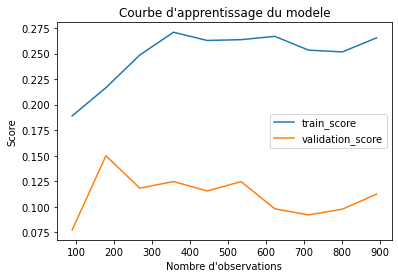

In [ ]:
N, train_score, val_score = learning_curve(KNR_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_KNR)

,0
0.988,0.14
1.053,0.43
1.048,2.06
0.774,0.18
1.007,0.74
...,...
1.173,0.88
1.969,0.59
0.478,1.33
1.324,1.37


#### Random Forest Regressor

In [ ]:
hyper_params_RFR = {'n_estimators' : [20, 50, 100, 150],
                'criterion':["squared_error", "absolute_error"]
               }

In [ ]:
RFR_model = RandomForestRegressor()
grid_RFR = GridSearchCV(RFR_model, hyper_params_RFR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_RFR.fit(X_train,y_train)
print(grid_RFR.best_params_)

{'criterion': 'absolute_error', 'n_estimators': 100}
Wall time: 6min 7s


In [ ]:
%%time
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)

Wall time: 58.7 s


RandomForestRegressor(criterion='absolute_error')

In [ ]:
%%time
y_pred_RFR = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_RFR))
print(mean_squared_error(y_test, y_pred_RFR))
print(r2_score(y_test, y_pred_RFR))

0.6701263422818792
4.40823637692114
0.504111713248024
Wall time: 25.5 ms


In [ ]:
pd.DataFrame(y_test, y_pred_RFR)

,0
0.3009,0.14
1.3241,0.43
1.9866,2.06
0.2873,0.18
1.2541,0.74
...,...
1.1292,0.88
0.4516,0.59
1.0977,1.33
1.0302,1.37


#### Support Vector Regressor

In [ ]:
hyper_params_SVR = {'gamma' : ["scale", "auto"],
                'C':[1, 10, 100, 1000, 10000, 100000]
               }

In [ ]:
SVR_model = SVR()
grid_SVR = GridSearchCV(SVR_model, hyper_params_SVR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_SVR.fit(X_train,y_train)
print(grid_SVR.best_params_)

{'C': 10, 'gamma': 'scale'}
Wall time: 25.4 s


In [ ]:
%%time
SVR_model = grid_SVR.best_estimator_
SVR_model.fit(X_train,y_train)

Wall time: 252 ms


SVR(C=10)

In [ ]:
%%time
y_pred_SVR = SVR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_SVR))
print(mean_squared_error(y_test, y_pred_SVR))
print(r2_score(y_test, y_pred_SVR))

1.2126671211395748
8.396596906850725
0.055455810744598266
Wall time: 125 ms


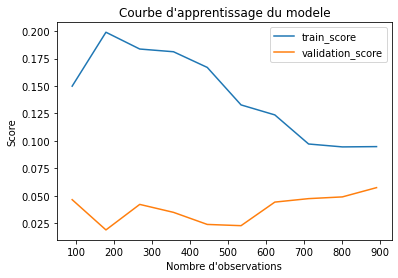

In [ ]:
N, train_score, val_score = learning_curve(SVR_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_SVR)

,0
0.615285,0.14
0.725276,0.43
0.813029,2.06
0.580542,0.18
0.756737,0.74
...,...
0.695662,0.88
1.319790,0.59
0.506841,1.33
0.962778,1.37


#### AdaBoostRegressor

In [ ]:
hyper_params_ADA = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
ADA_model = AdaBoostRegressor()
grid_ADA = GridSearchCV(ADA_model, hyper_params_ADA, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_ADA.fit(X_train,y_train)
print(grid_ADA.best_params_)

{'learning_rate': 1, 'n_estimators': 10}
Wall time: 33 s


In [ ]:
%%time
ADA_model = grid_ADA.best_estimator_
ADA_model.fit(X_train,y_train)

Wall time: 142 ms


AdaBoostRegressor(learning_rate=1, n_estimators=10)

In [ ]:
%%time
y_pred_ADA = ADA_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_ADA))
print(mean_squared_error(y_test, y_pred_ADA))
print(r2_score(y_test, y_pred_ADA))

0.9995381364991379
5.053632894227245
0.43151021326536054
Wall time: 7.76 ms


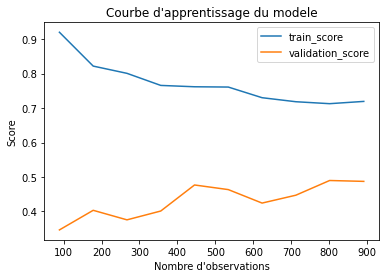

In [ ]:
N, train_score, val_score = learning_curve(ADA_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_ADA)

,0
0.746313,0.14
0.987113,0.43
2.418138,2.06
0.746313,0.18
0.987113,0.74
...,...
1.321916,0.88
1.027920,0.59
2.031967,1.33
0.746313,1.37


#### GradientBoostingRegressor

In [ ]:
hyper_params_GBR = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
GB_model = GradientBoostingRegressor()
grid_GBR = GridSearchCV(GB_model , hyper_params_GBR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_GBR.fit(X_train,y_train)
print(grid_GBR.best_params_)

{'learning_rate': 1, 'n_estimators': 10}
Wall time: 31.1 s


overflow encountered in square


In [ ]:
%%time
GBR_model = grid_GBR.best_estimator_
GBR_model.fit(X_train,y_train)

Wall time: 91.8 ms


GradientBoostingRegressor(learning_rate=1, n_estimators=10)

In [ ]:
%%time
y_pred_GBR = GBR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_GBR))
print(mean_squared_error(y_test, y_pred_GBR))
print(r2_score(y_test, y_pred_GBR))

0.920534419029139
5.04957163212799
0.43196706996093015
Wall time: 3.52 ms


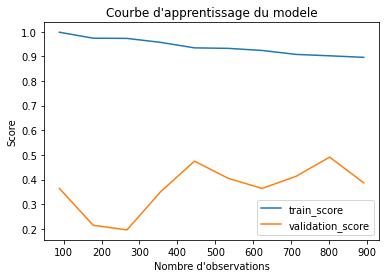

In [ ]:
N, train_score, val_score = learning_curve(GBR_model , X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_GBR)

,0
0.679064,0.14
0.995759,0.43
2.325079,2.06
0.204047,0.18
0.995759,0.74
...,...
0.808658,0.88
0.276438,0.59
1.100050,1.33
1.308167,1.37


#### XGBoostRegressor

In [ ]:
hyper_params_XGB = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

param_grid_XGB={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],}

In [ ]:
XGB_model = xgb.XGBRegressor()
grid_XGB = GridSearchCV(XGB_model, param_grid_XGB, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_XGB.fit(X_train,y_train)

Wall time: 7min 52s


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [ ]:
%%time
XGB_model = grid_XGB.best_estimator_
XGB_model.fit(X_train,y_train)

Wall time: 326 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
%%time
y_pred_XGB = XGB_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_XGB))
print(mean_squared_error(y_test, y_pred_XGB))
print(r2_score(y_test, y_pred_XGB))

0.7680088635681871
4.538186879840318
0.4894934108828144
Wall time: 9.48 ms


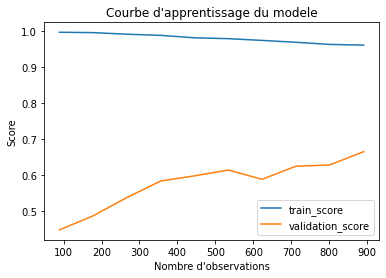

In [ ]:
N, train_score, val_score = learning_curve(XGB_model, X_train, y_train, cv=4, scoring = "r2",
                                           train_sizes = np.linspace(0.1,1,10))
plt.title("Courbe d'apprentissage du modele")
plt.plot(N, train_score.mean(axis=1), label="train_score")
plt.plot(N, val_score.mean(axis=1), label="validation_score")
plt.xlabel("Nombre d'observations")
plt.ylabel("Score")
plt.legend()

In [ ]:
pd.DataFrame(y_test, y_pred_XGB)

,0
0.307771,0.14
0.890045,0.43
1.600626,2.06
0.208949,0.18
1.002463,0.74
...,...
0.819815,0.88
0.486125,0.59
1.247909,1.33
0.619534,1.37


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,298.000000
mean,1.623926
std,2.986554
min,0.020000
25%,0.340000
50%,0.840000
75%,1.702500
max,34.090000


In [ ]:
print("KNR MAE :" + str(mean_absolute_error(y_test, y_pred_KNR)))
print("KNR MSE :" +str(mean_squared_error(y_test, y_pred_KNR)))
print("KNR R2" +str(r2_score(y_test, y_pred_KNR)))

print("RFR MAE :" + str(mean_absolute_error(y_test, y_pred_RFR)))
print("RFR MSE :" +str(mean_squared_error(y_test, y_pred_RFR)))
print("RFR R2 :" +str(r2_score(y_test, y_pred_RFR)))

print("SVR MAE :" + str(mean_absolute_error(y_test, y_pred_SVR)))
print("SVR MSE :" +str(mean_squared_error(y_test, y_pred_SVR)))
print("SVR R2 :" +str(r2_score(y_test, y_pred_SVR)))

print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))

print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GBR)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GBR)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GBR)))

print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

KNR MAE :1.2991476510067113
KNR MSE :7.267557194630872
KNR R20.18246296750661484
RFR MAE :0.6701263422818792
RFR MSE :4.40823637692114
RFR R2 :0.504111713248024
SVR MAE :1.2126671211395748
SVR MSE :8.396596906850725
SVR R2 :0.055455810744598266
ADA MAE :0.9995381364991379
ADA MSE :5.053632894227245
ADA R20.43151021326536054
GB MAE :0.920534419029139
GB MSE :5.04957163212799
GB R2 :0.43196706996093015
XGB MAE :0.7680088635681871
XGB MSE :4.538186879840318
XGB R2 :0.4894934108828144


**Le modele donnant les meilleurs resultats est le modele de randomforestregressor**

### Integration de l'Energy star score dans la modelisation

In [ ]:
df_modelisation = df_Building_energy.copy()

# supression des colonnes non utilisées pour la modelisation

del df_modelisation["BuildingType"]
del df_modelisation["PropertyName"]
del df_modelisation["Address"]
del df_modelisation["DefaultData"]
del df_modelisation["SteamUse(kBtu)"]
del df_modelisation["NaturalGas(kBtu)"]
del df_modelisation["Electricity(kBtu)"]
del df_modelisation["SiteEUI(kBtu/sf)"]
del df_modelisation['SiteEUIWN(kBtu/sf)']
del df_modelisation['SourceEUI(kBtu/sf)']
del df_modelisation['SourceEUIWN(kBtu/sf)']
del df_modelisation['PropertyGFATotal']
del df_modelisation['PropertyGFAParking']
del df_modelisation['PropertyGFABuilding(s)']
del df_modelisation['LargestPropertyUseTypeGFA']
del df_modelisation['ThirdLargestPropertyUseTypeGFA']
del df_modelisation['SecondLargestPropertyUseTypeGFA']


# imputation des Nan des aires des usages secondaires et tertiaires par 0

# imputation des Nan des aires des usages secondaires et tertiaires par 0

df_modelisation["part_ThirdLargestPropertyUseTypeGFA"] = df_modelisation["part_ThirdLargestPropertyUseTypeGFA"].fillna(0)
df_modelisation["part_SecondLargestPropertyUseTypeGFA"] = df_modelisation["part_SecondLargestPropertyUseTypeGFA"].fillna(0)

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'part_SteamUse', 'part_NaturalGas',
       'part_Electricity', 'part_LargestPropertyUseTypeGFA',
       'part_SecondLargestPropertyUseTypeGFA',
       'part_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [ ]:
### Creation d'une feature % d'aire des 3 usages de chaque propriété

In [ ]:
df_Building_energy["part_LargestPropertyUseTypeGFA"] = df_Building_energy["LargestPropertyUseTypeGFA"]/(df_Building_energy['PropertyGFATotal'])

df_Building_energy["part_SecondLargestPropertyUseTypeGFA"] = df_Building_energy["SecondLargestPropertyUseTypeGFA"]/(df_Building_energy['PropertyGFATotal'])

df_Building_energy["part_ThirdLargestPropertyUseTypeGFA"]  = df_Building_energy["ThirdLargestPropertyUseTypeGFA"]/(df_Building_energy['PropertyGFATotal'])

**Suppression des outliers**

In [ ]:
df_modelisation["Outlier"].value_counts()

non outlier     1498
Low outlier       13
High outlier       2
Name: Outlier, dtype: int64

In [ ]:
df_modelisation[df_modelisation["Outlier"]=="Low outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,part_LargestPropertyUseTypeGFA,part_SecondLargestPropertyUseTypeGFA,part_ThirdLargestPropertyUseTypeGFA
320,Retail Store,98105.0,4,NORTHEAST,47.66178,-122.31812,1987,2,Retail Store,Other,no tertiary use,100.0,3.189628e+05,3.189628e+05,Low outlier,2.22,0.03,0.0,0.000000,1.000000,1.004432,0.00000,0.0
383,Large Office,98104.0,2,DOWNTOWN,47.59878,-122.33458,1913,7,Office,no secondary use,no tertiary use,100.0,1.119592e+07,1.134876e+07,Low outlier,29.43,0.19,0.0,0.175759,0.824241,1.252953,0.00000,0.0
628,K-12 School,98109.0,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1,K-12 School,no secondary use,no tertiary use,100.0,4.314717e+05,4.314717e+05,Low outlier,11.54,0.32,0.0,0.428403,0.571597,1.000000,0.00000,0.0
693,Retail Store,98134.0,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1,Retail Store,Non-Refrigerated Warehouse,no tertiary use,100.0,1.454688e+05,1.454688e+05,Low outlier,5.46,0.14,0.0,0.663124,0.336876,0.626566,0.37594,0.0
775,Small- and Mid-Sized Office,98101.0,7,DOWNTOWN,47.61119,-122.33581,1903,3,Office,no secondary use,no tertiary use,NaN,2.410550e+04,2.410550e+04,Low outlier,0.17,0.00,0.0,0.000000,1.000000,0.433125,0.00000,0.0
817,Other,98101.0,7,DOWNTOWN,47.60711,-122.33886,1900,3,Other,no secondary use,no tertiary use,NaN,4.429350e+04,4.429350e+04,Low outlier,0.31,0.01,0.0,0.000000,1.000000,0.482697,0.00000,0.0
932,Worship Facility,98126.0,1,SOUTHWEST,47.51709,-122.37797,1971,1,Worship Facility,no secondary use,no tertiary use,100.0,1.008417e+05,1.008417e+05,Low outlier,0.70,0.03,0.0,0.000000,1.000000,1.000000,0.00000,0.0
1027,Small- and Mid-Sized Office,98133.0,3,CENTRAL,47.59973,-122.31331,1947,1,Office,no secondary use,no tertiary use,100.0,2.848573e+05,3.092140e+05,Low outlier,8.59,0.19,0.0,0.502263,0.497737,1.000000,0.00000,0.0
1131,K-12 School,98122.0,3,CENTRAL,47.60885,-122.29990,1929,2,K-12 School,no secondary use,no tertiary use,100.0,1.613634e+05,1.613634e+05,Low outlier,1.12,0.05,0.0,0.000000,1.000000,1.000000,0.00000,0.0
1166,Other,98134.0,2,GREATER DUWAMISH,47.58788,-122.33458,1910,3,Other,Parking,no tertiary use,NaN,1.680890e+04,1.726000e+04,Low outlier,0.12,0.00,0.0,0.000000,1.000000,0.892633,0.00000,0.0


In [ ]:
df_modelisation[df_modelisation["Outlier"]=="High outlier"]

,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,part_SteamUse,part_NaturalGas,part_Electricity,part_LargestPropertyUseTypeGFA,part_SecondLargestPropertyUseTypeGFA,part_ThirdLargestPropertyUseTypeGFA
167,Large Office,98101.0,7,DOWNTOWN,47.60642,-122.33581,1958,6,Office,Data Center,Parking,NaN,41399504.0,41650404.0,High outlier,362.66,2.10,0.0,0.038765,0.961235,0.577927,0.227584,0.144641
445,Large Office,98119.0,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,4,Office,Parking,Data Center,1.0,27137190.0,27137190.0,High outlier,189.18,1.46,0.0,0.000000,1.000000,0.635063,0.328056,0.036881


In [ ]:
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='Low outlier'].index, inplace=True)
df_modelisation.drop(df_modelisation.loc[df_modelisation['Outlier']=='High outlier'].index, inplace=True)
del df_modelisation['Outlier']

In [ ]:
df_modelisation.columns

Index(['PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'part_SteamUse', 'part_NaturalGas', 'part_Electricity',
       'part_LargestPropertyUseTypeGFA',
       'part_SecondLargestPropertyUseTypeGFA',
       'part_ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [ ]:
# création des 3 classes de batiments par étage

In [ ]:
df_modelisation['NumberofFloors'].unique()

array([ 2,  8, 11,  6,  5, 10, 19,  7,  1,  3, 12,  4, 15, 25, 33, 23, 17,
       20, 36, 16, 22, 47, 41, 29, 34, 14, 49, 37, 42, 63, 13, 18, 24, 21,
       55, 46, 30, 56,  9,  0, 76, 27, 99], dtype=int64)

In [ ]:
df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors']


In [ ]:
classes = {range(1, 2): 1, range(3, 6): 2, range(7, 1000): 3}

df_modelisation['NumberofFloorsClass'] = df_modelisation['NumberofFloors'].apply(lambda x: next((v for k, v in classes.items() if x in k), 0))

In [ ]:
df_modelisation['ENERGYSTARScore'].describe()

count    963.000000
mean      65.735202
std       28.380828
min        1.000000
25%       49.000000
50%       74.000000
75%       89.000000
max      100.000000
Name: ENERGYSTARScore, dtype: float64

In [ ]:
df_X, df_y = preprocessing_CO2(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

**KNR ENERGYSTARSCORE**

In [ ]:
hyper_params_KNR = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10],
                'weights':["uniform", "distance"],
                'algorithm':["auto", "ball_tree", "kd_tree", "brute"]
               }

In [ ]:
KNR_model = KNeighborsRegressor()
grid_KNR = GridSearchCV(KNR_model, hyper_params_KNR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_KNR.fit(X_train,y_train)
print(grid_KNR.best_params_)

{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Wall time: 3.36 s


In [ ]:
%%time
KNR_model = grid_KNR.best_estimator_
KNR_model.fit(X_train,y_train)
y_pred_KNR = KNR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_KNR))
print(mean_squared_error(y_test, y_pred_KNR))
print(r2_score(y_test, y_pred_KNR))

0.9274627976190475
2.622626286139456
0.17880360006507745
Wall time: 16.4 ms


**RFR ENERGYSTARSCORE**

In [ ]:
hyper_params_RFR = {'n_estimators' : [20, 50, 100, 150],
                'criterion':["squared_error", "absolute_error"]
               }

In [ ]:
RFR_model = RandomForestRegressor()
grid_RFR = GridSearchCV(RFR_model, hyper_params_RFR, scoring = "r2", cv = 4)

In [ ]:
grid_RFR.fit(X_train,y_train)
print(grid_RFR.best_params_)

{'criterion': 'squared_error', 'n_estimators': 100}


In [ ]:
%%time
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred_RFR = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_RFR))
print(mean_squared_error(y_test, y_pred_RFR))
print(r2_score(y_test, y_pred_RFR))

0.3567760416666667
0.8907819435416672
0.7210784742647267
Wall time: 1.44 s


**SVR ENERGYSTARSCORE**

In [ ]:
hyper_params_SVR = {'gamma' : ["scale", "auto"],
                'C':[1, 10, 100, 1000, 10000, 100000]
               }

In [ ]:
SVR_model = SVR()
grid_SVR = GridSearchCV(SVR_model, hyper_params_SVR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_SVR.fit(X_train,y_train)
print(grid_SVR.best_params_)

{'C': 10, 'gamma': 'scale'}
Wall time: 17.6 s


In [ ]:
%%time
SVR_model = grid_SVR.best_estimator_
SVR_model.fit(X_train,y_train)
y_pred_SVR = SVR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_SVR))
print(mean_squared_error(y_test, y_pred_SVR))
print(r2_score(y_test, y_pred_SVR))

0.8148250264641924
2.1108703660632187
0.33904454687210717
Wall time: 166 ms


**ADA ENERGYSTARSCORE**

In [ ]:
hyper_params_ADA = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
ADA_model = AdaBoostRegressor()
grid_ADA = GridSearchCV(ADA_model, hyper_params_ADA, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_ADA.fit(X_train,y_train)
print(grid_ADA.best_params_)

{'learning_rate': 1, 'n_estimators': 10}
Wall time: 23.5 s


In [ ]:
%%time
ADA_model = grid_ADA.best_estimator_
ADA_model.fit(X_train,y_train)
y_pred_ADA = ADA_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_ADA))
print(mean_squared_error(y_test, y_pred_ADA))
print(r2_score(y_test, y_pred_ADA))

0.6888015044590915
1.3984645326260117
0.5621129683254884
Wall time: 88.9 ms


**GBR ENERGYSTARSCORE**

In [ ]:
hyper_params_GBR = {'n_estimators' : [10,20,30,40, 50, 100, 150],
                'learning_rate':[1, 5,10]
               }

In [ ]:
GB_model = GradientBoostingRegressor()
grid_GBR = GridSearchCV(GB_model , hyper_params_GBR, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_GBR.fit(X_train,y_train)
print(grid_GBR.best_params_)

overflow encountered in square


{'learning_rate': 1, 'n_estimators': 50}
Wall time: 18.4 s


In [ ]:
%%time
GBR_model = grid_GBR.best_estimator_
GBR_model.fit(X_train,y_train)
y_pred_GBR = GBR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_GBR))
print(mean_squared_error(y_test, y_pred_GBR))
print(r2_score(y_test, y_pred_GBR))

0.5287701741782894
1.098882950909396
0.6559179140368474
Wall time: 279 ms


**XGB ENERGYSTARSCORE**

In [ ]:
param_grid_XGB={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],}

In [ ]:
XGB_model = xgb.XGBRegressor()
grid_XGB = GridSearchCV(XGB_model, param_grid_XGB, scoring = "r2", cv = 4)

In [ ]:
%%time
grid_XGB.fit(X_train,y_train)
XGB_model = grid_XGB.best_estimator_
XGB_model.fit(X_train,y_train)
y_pred_XGB = XGB_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred_XGB))
print(mean_squared_error(y_test, y_pred_XGB))
print(r2_score(y_test, y_pred_XGB))

0.4307623267885841
0.633149906195386
0.8017481841257129
Wall time: 6min 31s


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,192.000000
mean,1.218750
std,1.791755
min,0.040000
25%,0.297500
50%,0.645000
75%,1.387500
max,16.910000


In [ ]:
print("KNR MAE :" + str(mean_absolute_error(y_test, y_pred_KNR)))
print("KNR MSE :" +str(mean_squared_error(y_test, y_pred_KNR)))
print("KNR R2" +str(r2_score(y_test, y_pred_KNR)))

print("RFR MAE :" + str(mean_absolute_error(y_test, y_pred_RFR)))
print("RFR MSE :" +str(mean_squared_error(y_test, y_pred_RFR)))
print("RFR R2 :" +str(r2_score(y_test, y_pred_RFR)))

print("SVR MAE :" + str(mean_absolute_error(y_test, y_pred_SVR)))
print("SVR MSE :" +str(mean_squared_error(y_test, y_pred_SVR)))
print("SVR R2 :" +str(r2_score(y_test, y_pred_SVR)))

print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))

print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GBR)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GBR)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GBR)))

print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

KNR MAE :0.9274627976190475
KNR MSE :2.622626286139456
KNR R20.17880360006507745
RFR MAE :0.3567760416666667
RFR MSE :0.8907819435416672
RFR R2 :0.7210784742647267
SVR MAE :0.8148250264641924
SVR MSE :2.1108703660632187
SVR R2 :0.33904454687210717
ADA MAE :0.6888015044590915
ADA MSE :1.3984645326260117
ADA R20.5621129683254884
GB MAE :0.5287701741782894
GB MSE :1.098882950909396
GB R2 :0.6559179140368474
XGB MAE :0.4307623267885841
XGB MSE :0.633149906195386
XGB R2 :0.8017481841257129


**Nous obtenons de bien meilleurs resultats avec integration de l'energystarscore**

#### Selection de features par model.features_importance

In [ ]:
pd.set_option('display.max_rows', 50)
features_rfr = pd.DataFrame(RFR_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)
features_rfr

,0
SiteEnergyUse(kBtu),0.328433
part_Electricity,0.210094
LargestPropertyUseType_Supermarket/Grocery Store,0.101041
part_ThirdLargestPropertyUseTypeGFA,0.079787
ENERGYSTARScore,0.057800
...,...
LargestPropertyUseType_Other - Services,0.000000
LargestPropertyUseType_Other - Restaurant/Bar,0.000000
LargestPropertyUseType_Other - Recreation,0.000000
LargestPropertyUseType_Other - Public Services,0.000000


In [ ]:
features_rfr.shape

(238, 1)

<AxesSubplot:title={'center':'Importance des Features dans le modèle RandomforestRegressor'}>

<Figure size 1440x720 with 0 Axes>

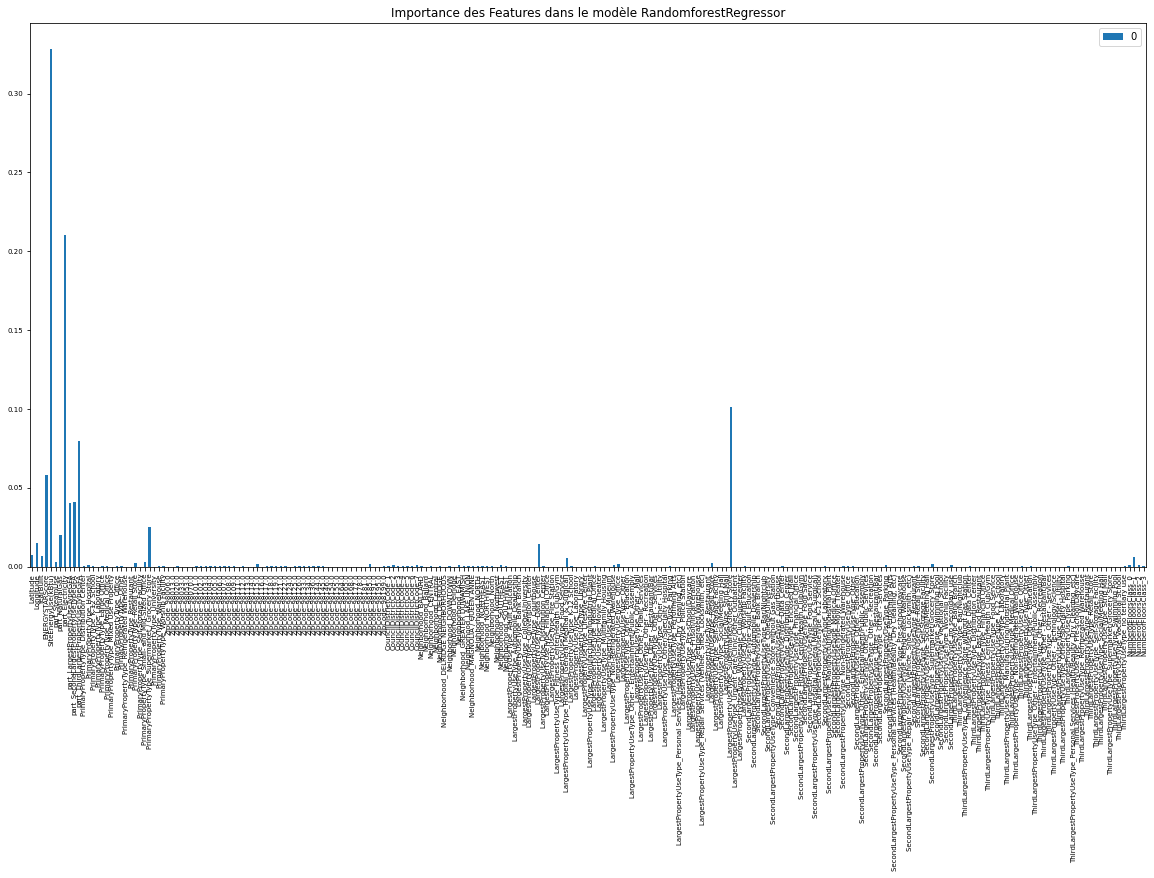

In [ ]:
pd.set_option('display.max_rows', 60)

plt.figure(figsize= (20,10))
pd.DataFrame(RFR_model.feature_importances_,
             index = df_X.columns).plot.bar(figsize= (20,10),
                                            fontsize=7,
                                            title ="Importance des Features dans le modèle RandomforestRegressor")

In [ ]:
features_rfr.columns=["feature_importance"]

In [ ]:
features_rfr.columns

Index(['feature_importance'], dtype='object')

In [ ]:
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)
features_rfr.head(20)

,feature_importance
SiteEnergyUse(kBtu),0.328433
part_Electricity,0.210094
LargestPropertyUseType_Supermarket/Grocery Store,0.101041
part_ThirdLargestPropertyUseTypeGFA,0.079787
ENERGYSTARScore,0.057800
part_SecondLargestPropertyUseTypeGFA,0.040789
part_LargestPropertyUseTypeGFA,0.040268
PrimaryPropertyType_Supermarket / Grocery Store,0.025279
part_NaturalGas,0.019896
Longitude,0.014897


In [ ]:
# création d'un dictionnaire des variables selectionnées selon leur nombre

d_feat_imp = {}
for i in range (1,240):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

In [ ]:
%%time
d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_CO2(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
    RFR_model.fit(X_train,y_train)
    y_pred = RFR_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)

Wall time: 4min 8s


In [ ]:
# Quel est le nombre de variables pour les 10 MAE minimales

from operator import itemgetter
  
K = 10

res = dict(sorted(d_n_feat_imp_MAE.items(), key = itemgetter(1))[:K]) 

print(str(res)) 

{215: 0.3453828125, 238: 0.34740989583333337, 102: 0.3479593750000001, 57: 0.3481463541666667, 177: 0.34974010416666673, 37: 0.34989687500000005, 114: 0.3517947916666668, 30: 0.35209375000000004, 176: 0.35251041666666677, 82: 0.3527630208333334}


In [ ]:
# Quel est le nombre de variables pour lequel la MAE est minimale

n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
n

215

In [ ]:
# Quel est le nombre de variables pour les 10 MAE minimales

from operator import itemgetter
  
K = 10

res = dict(sorted(d_n_feat_imp_MAE.items(), key = itemgetter(1))[:K]) 

print(str(res)) 

{215: 0.3453828125, 238: 0.34740989583333337, 102: 0.3479593750000001, 57: 0.3481463541666667, 177: 0.34974010416666673, 37: 0.34989687500000005, 114: 0.3517947916666668, 30: 0.35209375000000004, 176: 0.35251041666666677, 82: 0.3527630208333334}


In [ ]:
# recupérons ne nombre de variable minimal sur ces 10 plus faibles valeurs de MAE
A = res.keys()
n = min(A)
n

30

Text(0, 0.5, 'Mean absolute error')

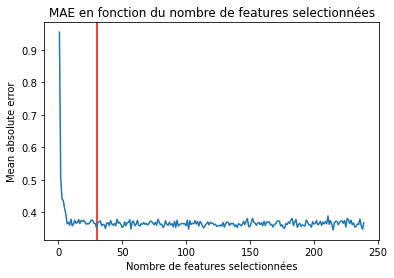

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
features_a_conserver_imp = features_rfr.head(n).index.tolist()
features_a_conserver_imp

['SiteEnergyUse(kBtu)',
 'part_Electricity',
 'LargestPropertyUseType_Supermarket/Grocery Store',
 'part_ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'part_SecondLargestPropertyUseTypeGFA',
 'part_LargestPropertyUseTypeGFA',
 'PrimaryPropertyType_Supermarket / Grocery Store',
 'part_NaturalGas',
 'Longitude',
 'LargestPropertyUseType_Data Center',
 'Latitude',
 'YearBuilt',
 'NumberofFloorsClass_1',
 'LargestPropertyUseType_Hospital (General Medical & Surgical)',
 'part_SteamUse',
 'PrimaryPropertyType_Small- and Mid-Sized Office',
 'PrimaryPropertyType_Retail Store',
 'LargestPropertyUseType_Retail Store',
 'ZipCode_98115.0',
 'LargestPropertyUseType_Office',
 'SecondLargestPropertyUseType_Supermarket/Grocery Store',
 'ZipCode_98185.0',
 'Neighborhood_SOUTHEAST',
 'Neighborhood_EAST',
 'SecondLargestPropertyUseType_Parking',
 'NumberofFloorsClass_0',
 'NumberofFloorsClass_2',
 'LargestPropertyUseType_Non-Refrigerated Warehouse',
 'CouncilDistrictCode_7']

In [ ]:
# Nous conserverons les features selectionnées

df_X,df_y= preprocessing_CO2(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
grid_RFR.fit(X_train,y_train)
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.37161770833333335
0.9896291022916666
0.6901274648363941


In [ ]:
pd.DataFrame(y_test, y_pred)

,0
1.5946,1.37
1.6738,2.11
1.5156,0.67
2.3720,1.83
2.7660,2.39
...,...
0.7986,0.70
0.7508,0.64
0.6560,0.45
2.3816,3.69


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,192.000000
mean,1.218750
std,1.791755
min,0.040000
25%,0.297500
50%,0.645000
75%,1.387500
max,16.910000


In [ ]:
pd.DataFrame(y_test, y_pred).reset_index().describe()

,index,0
count,192.000000,192.000000
mean,1.248134,1.218750
std,1.393614,1.791755
min,0.046000,0.040000
25%,0.350050,0.297500
50%,0.767100,0.645000
75%,1.610700,1.387500
max,7.266600,16.910000


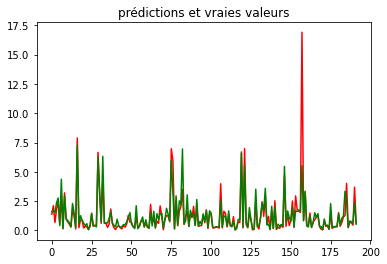

In [ ]:
plt.title("prédictions et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')

##### Score des différents modeles apres feature selection model.feature_importance

In [ ]:
#ADA

df_X, df_y = preprocessing_CO2(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_ADA.fit(X_train,y_train)
ADA_model = grid_ADA.best_estimator_
ADA_model.fit(X_train,y_train)

features_rfr = pd.DataFrame(ADA_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)

features_rfr.columns=["feature_importance"]
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)

d_feat_imp = {}
for i in range (1,240):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_CO2(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
#    grid_ADA.fit(X_train,y_train)
#    ADA_model = grid_ADA.best_estimator_
    ADA_model.fit(X_train,y_train)
    y_pred = ADA_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)
    
n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
    
features_a_conserver_imp = features_rfr.head(n).index.tolist()

df_X,df_y= preprocessing_CO2(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_ADA.fit(X_train,y_train)
ADA_model = grid_ADA.best_estimator_
y_pred_ADA = ADA_model.predict(X_test)

print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))


ADA MAE :0.6859924599830798
ADA MSE :1.4743928690349009
ADA R20.5383382975530808


In [ ]:
n

4

Text(0, 0.5, 'Mean absolute error')

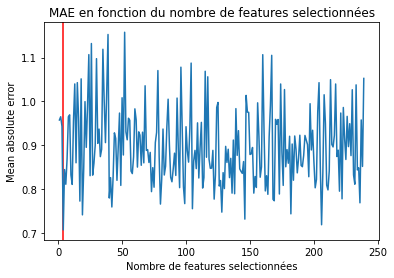

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
#GBR

df_X, df_y = preprocessing_CO2(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_GBR.fit(X_train,y_train)
GBR_model = grid_GBR.best_estimator_
GBR_model.fit(X_train,y_train)

features_rfr = pd.DataFrame(GBR_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)
features_rfr.columns=["feature_importance"]
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)

d_feat_imp = {}
for i in range (1,240):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_CO2(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
#    grid_GBR.fit(X_train,y_train)
#    GBR_model = grid_GBR.best_estimator_
    GBR_model.fit(X_train,y_train)
    y_pred = GBR_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)
    
n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
    
features_a_conserver_imp = features_rfr.head(n).index.tolist()

df_X,df_y= preprocessing_CO2(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_GBR.fit(X_train,y_train)
GBR_model = grid_GBR.best_estimator_
y_pred_GB = GBR_model.predict(X_test)


print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GB)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GB)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GB)))

overflow encountered in square


GB MAE :0.4209751493816027
GB MSE :0.5830046733503277
GB R2 :0.8174496528801029


overflow encountered in square


In [ ]:
n

7

Text(0, 0.5, 'Mean absolute error')

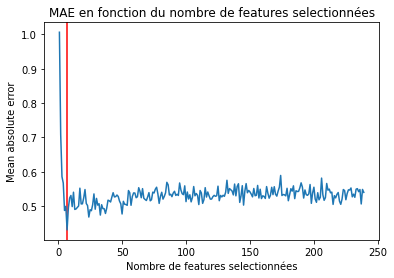

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
# XGB

df_X, df_y = preprocessing_CO2(df_modelisation)

X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_XGB.fit(X_train,y_train)
XGB_model = grid_XGB.best_estimator_
XGB_model.fit(X_train,y_train)


features_rfr = pd.DataFrame(XGB_model.feature_importances_, index = df_X.columns).sort_values(by = 0, ascending = False)

features_rfr.columns=["feature_importance"]
features_rfr.sort_values(by=["feature_importance"],ascending=False,inplace=True)

d_feat_imp = {}
for i in range (1,240):
    d_feat_imp[i] = features_rfr.head(i).index.tolist()

d_n_feat_imp_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_CO2(df_modelisation)
    df_X = df_X[d_feat_imp.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
#    grid_XGB.fit(X_train,y_train)
#    XGB_model = grid_XGB.best_estimator_
    XGB_model.fit(X_train,y_train)
    y_pred = XGB_model.predict(X_test)
    d_n_feat_imp_MAE[i] = mean_absolute_error(y_test, y_pred)
    
n = min(d_n_feat_imp_MAE, key=d_n_feat_imp_MAE.get)
    
features_a_conserver_imp = features_rfr.head(n).index.tolist()

df_X,df_y= preprocessing_CO2(df_modelisation)
df_X = df_X[features_a_conserver_imp]
X = df_X.values
y = df_y.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

grid_XGB.fit(X_train,y_train)
XGB_model = grid_XGB.best_estimator_
#XGB_model.fit(X_train,y_train)
y_pred_XGB = XGB_model.predict(X_test)


print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

XGB MAE :0.3947884799340196
XGB MSE :0.7608822841493632
XGB R2 :0.7617526386355709


In [ ]:
n

96

Text(0, 0.5, 'Mean absolute error')

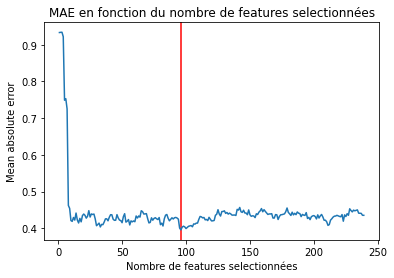

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_imp_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
%%time

print("ADA MAE :" + str(mean_absolute_error(y_test, y_pred_ADA)))
print("ADA MSE :" +str(mean_squared_error(y_test, y_pred_ADA)))
print("ADA R2" +str(r2_score(y_test, y_pred_ADA)))

print("GB MAE :" + str(mean_absolute_error(y_test, y_pred_GB)))
print("GB MSE :" +str(mean_squared_error(y_test, y_pred_GB)))
print("GB R2 :" +str(r2_score(y_test, y_pred_GB)))

print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

ADA MAE :0.6859924599830798
ADA MSE :1.4743928690349009
ADA R20.5383382975530808
GB MAE :0.4209751493816027
GB MSE :0.5830046733503277
GB R2 :0.8174496528801029
XGB MAE :0.3947884799340196
XGB MSE :0.7608822841493632
XGB R2 :0.7617526386355709
Wall time: 2.72 ms


#### Shap

In [ ]:
df_X,df_y= preprocessing_CO2(df_modelisation)
df_X = df_X
X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
grid_RFR.fit(X_train,y_train)
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.3742750000000001
1.02538743625
0.6789308199810269


In [ ]:
shap.initjs()

In [ ]:
#TreeExplainer, TreeGainExplainer, TreeMapleExplainer 

In [ ]:
X_test_shap = pd.DataFrame(X_test, columns = df_X.columns)

In [ ]:
tree_explainer1 = shap.TreeExplainer(RFR_model)

#### Shap global

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


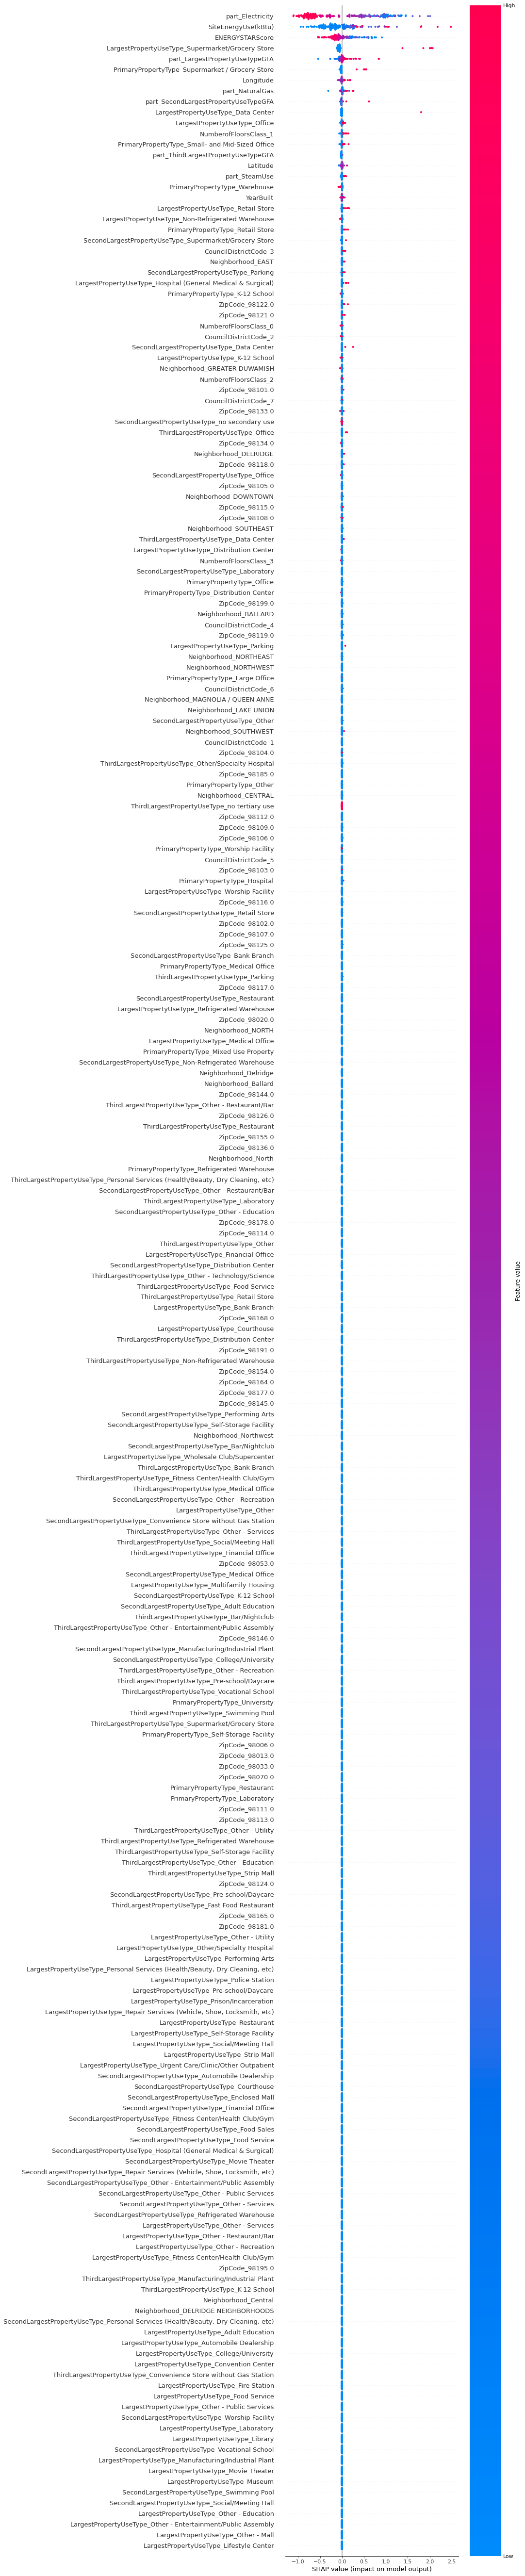

In [ ]:
shap_values = tree_explainer1.shap_values(X_test_shap)
shap.summary_plot(shap_values, X_test_shap, max_display = 300)

##### Selection des features par shap

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_test_shap.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(20)

,col_name,feature_importance_vals
7,part_Electricity,0.719857
4,SiteEnergyUse(kBtu),0.341683
3,ENERGYSTARScore,0.203381
149,LargestPropertyUseType_Supermarket/Grocery Store,0.127538
8,part_LargestPropertyUseTypeGFA,0.058043
25,PrimaryPropertyType_Supermarket / Grocery Store,0.035696
1,Longitude,0.021010
6,part_NaturalGas,0.018646
9,part_SecondLargestPropertyUseTypeGFA,0.017830
108,LargestPropertyUseType_Data Center,0.017361


In [ ]:
feature_importance.shape

(238, 2)

In [ ]:
# création d'un dictionnaire des variables selectionnées selon leur nombre

d_feat_shap = {}
for i in range (1,240):
    d_feat_shap[i] = feature_importance["col_name"].head(i).tolist()

In [ ]:
d_n_feat_shap_MAE = {}

for i in range (1,240):
    df_X,df_y= preprocessing_CO2(df_modelisation)
    df_X = df_X[d_feat_shap.get(i)]
    X = df_X.values
    y = df_y.values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
    RFR_model.fit(X_train,y_train)
    y_pred = RFR_model.predict(X_test)
    d_n_feat_shap_MAE[i] = mean_absolute_error(y_test, y_pred)

In [ ]:
# Quel est le nombre de variables pour lequel la MAE est minimale

n = min(d_n_feat_shap_MAE, key=d_n_feat_shap_MAE.get)
n

86

In [ ]:
# Quel est le nombre de variables pour les 10 MAE minimales

from operator import itemgetter
  
K = 10

res = dict(sorted(d_n_feat_shap_MAE.items(), key = itemgetter(1))[:K]) 

print(str(res)) 

{86: 0.3437520833333334, 199: 0.34395625, 212: 0.34540624999999997, 224: 0.345859375, 13: 0.346528125, 176: 0.347515625, 155: 0.34955416666666667, 78: 0.34966458333333333, 135: 0.35058541666666665, 171: 0.3518239583333333}


In [ ]:
# recupérons ne nombre de variable minimal sur ces 10 plus faibles valeurs de MAE
A = res.keys()
n = min(A)
n

13

Text(0, 0.5, 'Mean absolute error')

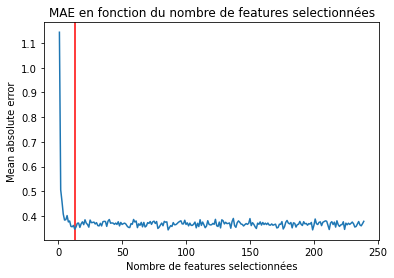

In [ ]:
plt.title("MAE en fonction du nombre de features selectionnées")
plt.axvline(x = n, color = "red", label = "Nbre de features selectionnées")
plt.plot(*zip(*sorted(d_n_feat_shap_MAE.items())))
plt.xlabel("Nombre de features selectionnées")
plt.ylabel("Mean absolute error")

In [ ]:
features_a_conserver_shap = feature_importance["col_name"].head(n).tolist()
features_a_conserver_shap

['part_Electricity',
 'SiteEnergyUse(kBtu)',
 'ENERGYSTARScore',
 'LargestPropertyUseType_Supermarket/Grocery Store',
 'part_LargestPropertyUseTypeGFA',
 'PrimaryPropertyType_Supermarket / Grocery Store',
 'Longitude',
 'part_NaturalGas',
 'part_SecondLargestPropertyUseTypeGFA',
 'LargestPropertyUseType_Data Center',
 'LargestPropertyUseType_Office',
 'NumberofFloorsClass_1',
 'PrimaryPropertyType_Small- and Mid-Sized Office']

##### Modele random forest regressor avec features shap

In [ ]:
df_X,df_y= preprocessing_CO2(df_modelisation)
df_X = df_X[features_a_conserver_shap]
X = df_X.values
y = df_y.values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [ ]:
grid_RFR.fit(X_train,y_train)
RFR_model = grid_RFR.best_estimator_
RFR_model.fit(X_train,y_train)
y_pred = RFR_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.3682156250000001
1.0137244076041667
0.6825827459862355


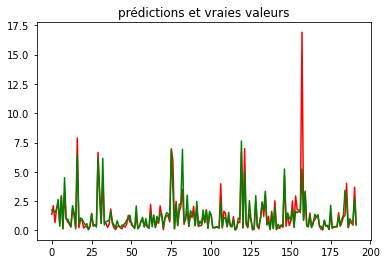

In [ ]:
plt.title("prédictions et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')

In [ ]:
pd.DataFrame(y_test).describe()

,0
count,192.000000
mean,1.218750
std,1.791755
min,0.040000
25%,0.297500
50%,0.645000
75%,1.387500
max,16.910000


#### Comparaison avec modeles naïf

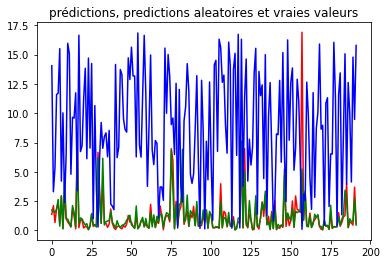

In [ ]:
y_pred_random = np.random.uniform(np.min(y_test),np.max(y_test),y_test.shape)

plt.title("prédictions, predictions aleatoires et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')
plt.plot(y_pred_random, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_random))
print(mean_squared_error(y_test, y_pred_random))
print(r2_score(y_test, y_pred_random))

7.9313054407752
85.71809876746681
-25.840039882589224


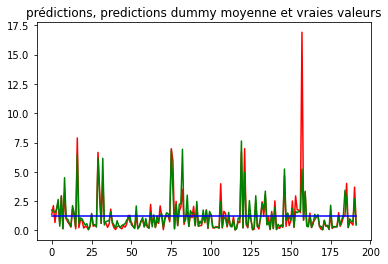

In [ ]:
dummy_reg = DummyRegressor(strategy = 'mean')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)


plt.title("prédictions, predictions dummy moyenne et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

1.0425812146892655
3.1955352155856502
-0.0005855690430858207


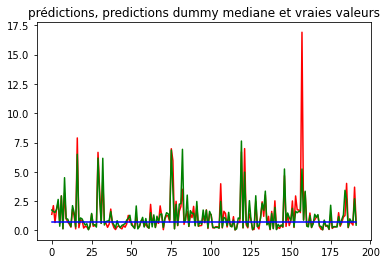

In [ ]:
dummy_reg = DummyRegressor(strategy = 'median')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)



plt.title("prédictions, predictions dummy mediane et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

0.9096874999999999
3.4732416666666666
-0.08754097670893723


# Modele selectionné : XGBOOST avec feature selection (MAE un peu moins bonne mais rapidité d'execution

In [ ]:
print("XGB MAE :" + str(mean_absolute_error(y_test, y_pred_XGB)))
print("XGB MSE :" +str(mean_squared_error(y_test, y_pred_XGB)))
print("XGB R2 :" +str(r2_score(y_test, y_pred_XGB)))

XGB MAE :0.3947884799340196
XGB MSE :0.7608822841493632
XGB R2 :0.7617526386355709


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,192.000000
mean,1.218750
std,1.791755
min,0.040000
25%,0.297500
50%,0.645000
75%,1.387500
max,16.910000


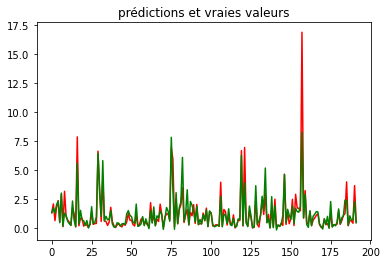

In [ ]:
plt.title("prédictions et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')

In [ ]:
pd.DataFrame(y_test, y_pred_XGB)

,0
1.343622,1.37
1.749152,2.11
1.331717,0.67
2.034387,1.83
2.349973,2.39
...,...
1.085329,0.70
0.723596,0.64
0.749263,0.45
2.318302,3.69


#### Comparaison avec modeles naïf

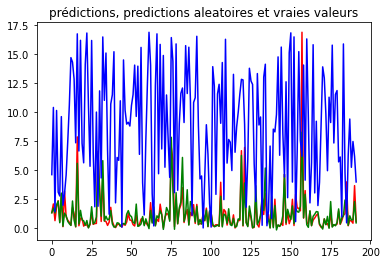

In [ ]:
y_pred_random = np.random.uniform(np.min(y_test),np.max(y_test),y_test.shape)

plt.title("prédictions, predictions aleatoires et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')
plt.plot(y_pred_random, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_random))
print(mean_squared_error(y_test, y_pred_random))
print(r2_score(y_test, y_pred_random))

7.896331017113362
84.23100095319622
-25.374400009350662


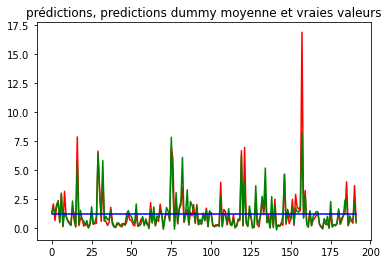

In [ ]:
dummy_reg = DummyRegressor(strategy = 'mean')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)


plt.title("prédictions, predictions dummy moyenne et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

1.0425812146892655
3.1955352155856502
-0.0005855690430858207


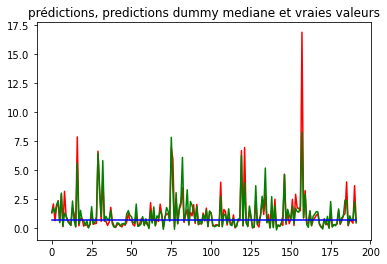

In [ ]:
dummy_reg = DummyRegressor(strategy = 'median')
dummy_reg.fit(X_train,y_train)
y_pred_dummy_reg = dummy_reg.predict(X_test)



plt.title("prédictions, predictions dummy mediane et vraies valeurs")
plt.plot(y_test, c='red')
plt.plot(y_pred_XGB, c='green')
plt.plot(y_pred_dummy_reg, c='blue')

In [ ]:
print(mean_absolute_error(y_test, y_pred_dummy_reg))
print(mean_squared_error(y_test, y_pred_dummy_reg))
print(r2_score(y_test, y_pred_dummy_reg))

0.9096874999999999
3.4732416666666666
-0.08754097670893723
